In [9]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import time
import importlib
from pathlib import Path
from datetime import datetime

from numba import jit
import numpy as np
import pandas as pd

# required to enable non-blocking interaction:
# %gui qt
# $env:QT_API="pyqt6"
%gui qt5
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance

import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# ## Panel:
import param
# import panel as pn
# from panel.interact import interact, interactive, fixed, interact_manual
# from panel.viewable import Viewer
# pn.extension()

# Pho's Formatting Preferences
# %config Completer.use_jedi = False
from pyphocorehelpers.preferences_helpers import set_pho_preferences
set_pho_preferences()

%config Completer.use_jedi = False

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.function_helpers import compose_functions
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter
from pyphocorehelpers.geometry_helpers import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
# from pyphoplacecellanalysis.General.ComputationResults import ComputationResult
from pyphoplacecellanalysis.General.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DefaultDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.Ratemaps import DefaultRatemapDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DefaultDecoderDisplayFunctions
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot import plot_raster_plot, _display_pyqtgraph_raster_plot

# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core

    importlib.reload(core)
except ImportError:
    sys.path.append(r"C:\Users\Pho\repos\NeuroPy")  # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print("neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.")
    from neuropy import core

# Neuropy:
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.laps import Laps
from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.analyses.laps import estimation_session_laps
from neuropy.core.epoch import NamedTimerange

from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.core.neuron_identities import NeuronIdentity, build_units_colormap, PlotStringBrevityModeEnum
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.plotting.ratemaps import enumTuningMap2DPlotVariables
# from neuropy.utils.mixins.time_slicing import verify_non_overlapping, add_PBE_identity
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping

known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.kdiba_old_format_session(a_base_dir)),
                               basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
                'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
                               basedir=Path('R:\data\Bapun\Day5TwoNovel'))
               }
known_data_session_type_dict['kdiba'].post_load_functions = [lambda a_loaded_sess: estimation_session_laps(a_loaded_sess)]

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

def compute_position_grid_bin_size(x, y, num_bins=(64,64), debug_print=False):
    """ Compute Required Bin size given a desired number of bins in each dimension
    Usage:
        active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64)
    """
    out_grid_bin_size, out_bins, out_bins_infos = compute_position_grid_size(x, y, num_bins=num_bins)
    active_grid_bin = tuple(out_grid_bin_size)
    if debug_print:
        print(f'active_grid_bin: {active_grid_bin}') # (3.776841861770752, 1.043326930905373)
    return active_grid_bin

# WARNING! TODO: Changing the smooth values from (1.5, 1.5) to (0.5, 0.5) was the difference between successful running and a syntax error!
# try:
#     active_grid_bin
# except NameError as e:
#     print('setting active_grid_bin = None')
#     active_grid_bin = None
# finally:
#     # active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name
#     active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name

## Dynamic mode:
def _build_active_computation_configs(sess):
    """ _get_computation_configs(curr_kdiba_pipeline.sess)
        # From Diba:
        # (3.777, 1.043) # for (64, 64) bins
        # (1.874, 0.518) # for (128, 128) bins

    """
    # active_grid_bin = compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64))
    # active_session_computation_config.computation_epochs = None # set the placefield computation epochs to None, using all epochs.
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(3.777, 1.043), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]

    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(32, 32)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #        ]

def JupyterLab_excepthook(exc_type, exc_value, exc_tb):
    tb = "".join(traceback.format_exception(exc_type, exc_value, exc_tb))
    print("JupyterLab_excepthook error catched!:")
    print("\t error message:\n", tb)
    QtWidgets.QApplication.quit()
    # or QtWidgets.QApplication.exit(0)
    
sys.excepthook = JupyterLab_excepthook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Bapun Format:

In [ ]:
# curr_bapun_pipeline = NeuropyPipeline(name='bapun_pipeline', session_data_type='bapun', basedir=known_data_session_type_dict['bapun'].basedir, load_function=known_data_session_type_dict['bapun'].load_function)
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type('bapun', known_data_session_type_dict['bapun'])
active_session_computation_configs = _build_active_computation_configs(curr_bapun_pipeline.sess)
# active_session_computation_config.grid_bin = compute_position_grid_bin_size(curr_bapun_pipeline.sess.position.x, curr_bapun_pipeline.sess.position.y, num_bins=(64, 64))

In [ ]:
# Bapun/DataFrame style session filter functions:
def build_bapun_any_epochs_filters(sess):
    return build_custom_epochs_filters(sess)
    
def build_bapun_any_maze_epochs_filters(sess):
    # all_filters = build_custom_epochs_filters(sess)
    # # print(f'all_filters: {all_filters}')
    # maze_only_filters = dict()
    # for (name, filter_fcn) in all_filters.items():
    #     if 'maze' in name:
    #         maze_only_filters[name] = filter_fcn
    # maze_only_filters = build_custom_epochs_filters(sess, included_epoch_labels=['maze1','maze2'])
    # { key:value for (key,value) in dictOfNames.items() if key % 2 == 0}
    # dict(filter(lambda elem: len(elem[1]) == 6,dictOfNames.items()))
    # maze_only_name_filter_fn = lambda dict: dict(filter(lambda elem: 'maze' in elem[0], dict.items()))
    maze_only_name_filter_fn = lambda names: list(filter(lambda elem: elem.startswith('maze'), names))
    # print(f'callable(maze_only_name_filter_fn): {callable(maze_only_name_filter_fn)}')
    # print(maze_only_name_filter_fn(['pre', 'maze1', 'post1', 'maze2', 'post2']))
    # lambda elem: elem[0] % 2 == 0
    maze_only_filters = build_custom_epochs_filters(sess, included_epoch_labels=maze_only_name_filter_fn)
    # print(f'maze_only_filters: {maze_only_filters}')
    return maze_only_filters

# active_session_filter_configurations = build_bapun_any_epochs_filters(curr_bapun_pipeline.sess)
active_session_filter_configurations = build_bapun_any_maze_epochs_filters(curr_bapun_pipeline.sess)
# print(f'active_session_filter_configurations: {active_session_filter_configurations}')
curr_bapun_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None  # set the placefield computation epochs to None, using all epochs.
curr_bapun_pipeline.perform_computations(active_session_computation_configs[0])
curr_bapun_pipeline.prepare_for_display() # TODO: pass a display config
# Set curr_active_pipeline for testing:
curr_active_pipeline = curr_bapun_pipeline

## KDiba Format:

In [2]:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type('kdiba', known_data_session_type_dict['kdiba'])
# active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
# active_session_computation_config.grid_bin = active_grid_bin
active_session_computation_configs = _build_active_computation_configs(curr_kdiba_pipeline.sess)

basedir is already Path object.
	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat... done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy... 2006-6-07_11-26-53.position.npy saved
done.
	 Failure loading .interpolated_spike_positions.npy. Must recompute.

	 Saving updated interpolated spike position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.interpolated_spike_positions.npy.

In [3]:
def build_any_maze_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    # active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')) } # just maze 1
    active_session_filter_configurations = {
        # 'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
    #                                     'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
    }
    return active_session_filter_configurations

active_session_filter_configurations = build_any_maze_epochs_filters(curr_kdiba_pipeline.sess)
curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0])
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline

Applying session filter named "maze"...
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Performing single_computation on filtered_session with filter named "maze"...
Performing perform_registered_computations(...) with 7 registered_computation_functions...
Recomputing active_epoch_placefields... 	 done.
Recomputing active_epoch_placefields2D... 	 done.


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:181: RuntimeWarning: overflow encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:182: RuntimeWarning: invalid value encountered in multiply
  result = C_tau_n * un_normalized_result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:221: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:236: RuntimeWarning: invalid value encountered 

perform_registered_computations(...): 
	accumulated_errors: []


In [ ]:
def build_pyramidal_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_pyramidal_epochs_filters(curr_kdiba_pipeline.sess)

is_non_overlapping_lap = get_non_overlapping_epochs(curr_kdiba_pipeline.sess.laps.to_dataframe()[['start','stop']].to_numpy())
only_good_laps_df = curr_kdiba_pipeline.sess.laps.to_dataframe()[is_non_overlapping_lap]
curr_kdiba_pipeline.sess.laps = Laps(only_good_laps_df) # replace the laps object with the filtered one

lap_specific_epochs = curr_kdiba_pipeline.sess.laps.as_epoch_obj()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(curr_kdiba_pipeline.sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])

# Copy the active session_computation_config:
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = any_lap_specific_epochs # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline

# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [4]:
# active_config_name = 'maze1'
active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
print(f'active_computed_data.keys(): {active_computed_data.keys()}')
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

display_output = dict()

active_computed_data.keys(): dict_keys(['pf1D', 'pf2D', 'pf2D_Decoder', 'pf2D_TwoStepDecoder', 'extended_stats', 'firing_rate_trends', 'placefield_overlap'])


In [5]:
list(curr_active_pipeline.computation_results.keys()) # ['maze1', 'maze2']

['maze']

## 3D Interactive Spike Raster Window

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget
spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df)

#### Test pg.SignalProxy to rate-limit update signals

In [ ]:
update_proxy = pg.SignalProxy(

## ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [ ]:
pActiveTuningCurvesPlotter = None
display_output = display_output | curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt') # Works now!
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

## ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [ ]:
pActiveSpikesBehaviorPlotter = None
display_output = display_output | curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_spike_and_behavior_browser, active_config_name, extant_plotter=display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = display_output['ipspikesDataExplorer']
display_output['pActiveSpikesBehaviorPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = display_output['pActiveSpikesBehaviorPlotter']

### Test Programmatic Updating of the ipspikesDataExplorer

In [ ]:
# spike_raster_window.spikes_window.on_window_changed()
# spike_raster_window.spikes_window.update_window_start(500.0) # doesn't update anything
# spike_raster_window.spike_raster_plt_2d.spikes_window.update_window_start(500.0) # doesn't update anything
spike_raster_window.spike_raster_plt_2d.update_scroll_window_region(500.0, 700.0, block_signals=False)

In [ ]:
spike_raster_window.shift_animation_frame_val(shift_frames=5)

In [ ]:
# spike_raster_window.spike_3d_to_2d_window_connection.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)

In [ ]:
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect()

In [ ]:
spike_raster_window.spike_raster_plt_2d.ui.scroll_window_region.sigRegionChanged.disconnect()

In [ ]:
## Need to the spike indicies that are currently visible in the raster window to programmatically update ipspikesDataExplorer's displayed spikes.
# active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df
# spike_raster_window.spike_raster_plt_2d.spikes_window
# curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df

# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df.index
# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
# np.shape(ipspikesDataExplorer.params.pre_computed_window_sample_indicies) # (51157, 299)

# np.shape(ipspikesDataExplorer.params.active_trail_opacity_values) # (299,)
## Hopefully ipspikesDataExplorer's slider will adjust automatically?

In [ ]:
## Test disabling the user-slider:
# ipspikesDataExplorer.interface_properties
# interactive_timestamp_slider_actor
# add_slider_widget

## When building widgets:
# self.p.add_callback(self.interface_properties, interval=16)  # to be smooth on 60Hz

# Removes all slider widgets:
# ipspikesDataExplorer.p.clear_slider_widgets()
# ipspikesDataExplorer.p.clear_button_widgets() # removes the play/pause toggle checkbox so that it can be driven externally
# ipspikesDataExplorer.p.update()
# ipspikesDataExplorer.p.render()

# ipspikesDataExplorer.p.button_widgets
# ipspikesDataExplorer.p.receivers()

# For the callback, it looks like I can check the timer here:
callback_timer = ipspikesDataExplorer.p._callback_timer  # QTimer
callback_timer.isActive()
# callback_timer.isSignalConnected()
# callback_timer.stop()

ipspikesDataExplorer

In [ ]:
spike_raster_window.animation_active_time_window.window_duration

In [ ]:
# Get the times that fall within the current plot window:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# np.shape(ipspikesDataExplorer.t) # (51455,)

# active_window_sample_indicies
active_included_all_window_position_indicies = ((ipspikesDataExplorer.t > curr_win_start) & (ipspikesDataExplorer.t < curr_win_end)) # Two Sided Range Mode
# active_included_all_window_position_indicies
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}') # (51455,)

# active_included_all_window_position_indicies = np.where(active_included_all_window_position_indicies) # was a boolean area, but get the indices where true instead
active_included_all_window_position_indicies = np.squeeze(active_included_all_window_position_indicies.nonzero()) # was a boolean area, but get the indices where true instead.  (1106,)
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}; active_included_all_window_position_indicies: {active_included_all_window_position_indicies}')

active_num_samples = len(active_included_all_window_position_indicies)

## TODO: I think active_included_all_window_position_indicies better be the same length as .params.active_trail_opacity_values and .params.active_trail_size_values
# ipspikesDataExplorer.params.curr_view_window_length_samples

max_num_samples = ipspikesDataExplorer.params.curr_view_window_length_samples # 299
if active_num_samples > max_num_samples:
    print(f'len(active_included_all_window_position_indicies) ({active_num_samples}) > max_num_samples ({max_num_samples}). Cutting.')
    active_included_all_window_position_indicies = active_included_all_window_position_indicies[-max_num_samples:] # get only the last (meaning most recent) max_num_samples samples from the indicies that should be displayed
    active_num_samples = max_num_samples # cut down to the max number of samples
    
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}') # np.shape(active_included_all_window_position_indicies): (1, 1106), active_num_samples: 1    

# print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}')    
# ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:]

## Animal Position and Location Trail Plotting:
ipspikesDataExplorer.perform_plot_location_trail('animal_location_trail', ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:],
                                     trail_fade_values=ipspikesDataExplorer.params.active_trail_opacity_values, trail_point_size_values=ipspikesDataExplorer.params.active_trail_size_values,
                                     render=False)

## Animal Current Position:
curr_animal_point = [ipspikesDataExplorer.x[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.y[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.z_fixed[-1]]
ipspikesDataExplorer.perform_plot_location_point('animal_current_location_point', curr_animal_point, render=False)



# curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way

In [ ]:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
ipspikesDataExplorer.on_active_window_update_mesh(curr_win_start, curr_win_end, enable_position_mesh_updates=True, render=True)

# ipspikesDataExplorer.on_programmatic_data_update(self, active_included_all_historical_indicies=None, active_included_recent_only_indicies=None, active_window_sample_indicies=None, curr_animal_point=None)

### Lap Example of programmatic updating:
# curr_lap_id = 0

# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
# curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
# curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
# curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
# curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

# curr_lap_num_spikes = len(curr_lap_spike_indicies)
# print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
## Can Programmaticallyt set the visibility on the different plotted elements:
ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# ipspikesDataExplorer.toggle_plot_visibility('spikes_main_recent_only')
# ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
# ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')
# toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
# toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

## TODO: CRITICAL: IMPORTANT: Add this function somewhere perminant to allow the window to control InteractivePlaceCellDataExplorer (ipspikesDataExplorer) objects;

In [ ]:

# def _connect_additional_controlled_plotter(spike_raster_plt_2d, controlled_spike_raster_plt):
#     # Perform Initial (one-time) update from source -> controlled:
#     controlled_spike_raster_plt.spikes_window.update_window_start_end(spike_raster_plt_2d.spikes_window.active_time_window[0], spike_raster_plt_2d.spikes_window.active_time_window[1])
#     # Connect to update self when video window playback position changes
#     sync_connection = spike_raster_plt_2d.window_scrolled.connect(controlled_spike_raster_plt.spikes_window.update_window_start_end)
#     return sync_connection


extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

## Explore Mesh/Cell Picking in ipcDataExplorer

In [ ]:
## Make the legend pickable:
import pyvista as pv

def callback(point):
    """Create a cube and a label at the click point."""
    mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])


ipcDataExplorer.p.enable_surface_picking(callback=callback, left_clicking=True, show_point=False)
# ipcDataExplorer.p.enable_surface_picking(

In [ ]:
def mesh_picked_callback(mesh):
    """TODO: highlight the mesh or something - label at the click point."""
    print(f'mesh_picked_callback(mesh: {mesh})')
    # mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    # ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    # ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])

ipcDataExplorer.p.enable_mesh_picking(callback=mesh_picked_callback, left_clicking=True, show=True)

### Other

In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_spike_and_behavior_browser, active_config_name) # this works now!

In [ ]:
display_dict = curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, active_config_name) # does not work, missing color info?
iplapsDataExplorer = display_dict['iplapsDataExplorer']
# plotter is available at
p = display_dict['plotter']

iplapsDataExplorer

In [ ]:
plots = curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, active_config_name) # works, but generates a TON of plots!

In [ ]:
len(plots) # 39
type(plots[0]) # matplotlib.figure.Figure

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)


In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

In [ ]:
curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n_and_x_prev') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_animated_2D, active_config_name, variable_name='p_x_given_n')

In [ ]:
app, win, w = curr_active_pipeline.display(DefaultRatemapDisplayFunctions._display_placemaps_pyqtplot_2D, active_config_name)
win.show(); pg.exec()

### Old Individual Plotting Functions:


In [ ]:
filter_name = 'maze1'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=10) # works!

In [ ]:
filter_name = 'maze2'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=11) # works!

In [ ]:
_display_result(curr_active_pipeline.computation_results['maze1'])

In [ ]:
_display_result(curr_active_pipeline.computation_results['maze2'])

In [ ]:
filter_name = 'maze1'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze2'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, 'maze1') # works!

In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!

# Common: Optional Saving

In [ ]:
from PendingNotebookCode import save_some_pipeline_data_to_h5
# Define Saving/Loading Directory and paths:
data_output_directory = Path('./data')
finalized_output_cache_file = data_output_directory.joinpath('pipeline_cache_store.h5') # '../../data/pipeline_cache_store.h5'
desired_spikes_df_key = '/filtered_sessions/maze1/spikes_df'

curr_epoch_labels = list(curr_active_pipeline.sess.epochs.labels) # ['pre', 'maze1', 'post1', 'maze2', 'post2']
curr_named_timeranges = [curr_active_pipeline.sess.epochs.get_named_timerange(a_label) for a_label in curr_epoch_labels]

curr_named_timeranges

all_filters_list = list(curr_active_pipeline.filtered_sessions.keys())
all_filters_list

In [ ]:
active_config_name = 'maze1'
# active_config_name = 'maze'


desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'
desired_positions_df_key = f'/filtered_sessions/{active_config_name}/pos_df'
# desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'



# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
print(f'active_computed_data.keys(): {active_computed_data.keys()}')
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()

In [ ]:
# desired_positions_df_key

save_some_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file)
# save_spikes_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file)        

In [ ]:
# reread = pd.read_hdf(finalized_output_cache_file, key='spikes_df')
# reread

# with pd.HDFStore(finalized_output_cache_file) as store:
#     print(store.keys())
    

# Load the saved .h5 spikes dataframe for testing:
spikes_df = pd.read_hdf(finalized_output_cache_file, key=desired_spikes_df_key)
pos_df = pd.read_hdf(finalized_output_cache_file, key=desired_positions_df_key)
# spikes_df
pos_df

In [ ]:
curr_active_pipeline.sess.epochs.t_start
curr_active_pipeline.sess.epochs.t_stop

## Testing burst detection: Calculate the spiking profile using pyspike and display the outputs:

In [ ]:
## Testing burst detection
from collections import OrderedDict
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats
from neurodsp.plts.time_series import plot_time_series, plot_bursts # for plotting results
import matplotlib.pyplot as plt

# PySpike version:
# TODO: See http://mariomulansky.github.io/PySpike/#tutorial for reference.
""" TODO:
I was reading through these, they seem pretty cool:
https://mark-kramer.github.io/Case-Studies-Python/08.html
https://mark-kramer.github.io/Case-Studies-Python/09.html


Cool Z-Score peak finding algorithm:
    https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data
Python Implementation:
    https://gist.github.com/ximeg/587011a65d05f067a29ce9c22894d1d2


"""
import pyspike as spk


# curr_active_pipeline.sess.spikes_df.spikes.neuron_ids

# grouped = curr_active_pipeline.sess.spikes_df.groupby('aclu')

# neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
# neuron_split_spike_dfs = curr_active_pipeline.sess.spikes_df.spikes.get_split_by_unit()

# grouped['t_rel_seconds'].diff()



out_pyspike_spiketrains = OrderedDict()
# spike_frequency_spectrum_list = []
for (i, a_cell_id) in enumerate(curr_active_pipeline.sess.spikes_df.spikes.neuron_ids):
    # if i == 0:
    # loop through the cell_ids  
    curr_df = curr_active_pipeline.sess.spikes_df.groupby('aclu').get_group(a_cell_id)

    # spike_train = SpikeTrain(np.array([0.1, 0.3, 0.45, 0.6, 0.9], [0.0, 1.0]))
    curr_spike_train = spk.SpikeTrain(curr_df[curr_df.spikes.time_variable_name].to_numpy(), [curr_active_pipeline.sess.epochs.t_start, curr_active_pipeline.sess.epochs.t_stop])
    out_pyspike_spiketrains[a_cell_id] = curr_spike_train
    # spike_frequency_spectrum = np.fft.rfft(curr_df[curr_df.spikes.time_variable_name])
    # spike_frequency_spectrum_list.append(spike_frequency_spectrum)

    # curr_active_pipeline.sess.spikes_df['scISI']
    # ValueError: autodetected range of [nan, nan] is not finite
    # curr_v_text = Text3D(f'unit[{a_cell_id}]', pos=(curr_unit_x_offset,-1), s=0.3, c='k', justify='center')
    # acts.append(curr_v_text)
    # curr_v = violin(curr_df['scISI'].dropna(), bins=20, x=curr_unit_x_offset, centerline=True, spline=False, vlim=[0, 10]) # width=20.0, 
    # curr_v = whisker(curr_df['scISI'].dropna(), s=0.25, c='k', lw=2, bc='blue', alpha=0.25, r=5, jitter=True, horizontal=False)
    # curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=True)
    # curr_v = violin(curr_df['scISI'])
    # acts.append(curr_v)
        
        
# spike_frequency_spectrum = np.fft.rfft(curr_active_pipeline.sess.spikes_df[curr_active_pipeline.sess.spikes_df.spikes.time_variable_name])


# .diff()
# curr_active_pipeline.sess.spikes_df
# spike_frequency_spectrum.shape # (466300,)

# Now the shape is (854,)
out_pyspike_spiketrains


# isi_profile = spk.isi_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
# x, y = isi_profile.get_plottable_data()
# plt.plot(x, y, '--k')
# print("ISI distance: %.8f" % isi_profile.avrg())
# plt.show()


# # Can specify the time intervals over which to look at the average ISI:
# isi1 = isi_profile.avrg(interval=(0, 1000))
# isi2 = isi_profile.avrg(interval=(1000, 2000))
# isi3 = isi_profile.avrg(interval=[(0, 1000), (2000, 3000)])
# isi4 = isi_profile.avrg(interval=[(1000, 2000), (3000, 4000)])

# spike_profile = spk.spike_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
# x, y = spike_profile.get_plottable_data()
# plt.plot(x, y, '--k')
# print("SPIKE distance: %.8f" % spike_profile.avrg())
# plt.show()



## Multivariate (across all spike trains at at time) version:
spiketrains_list = list(out_pyspike_spiketrains.values())
avrg_isi_profile = spk.isi_profile(spiketrains_list)
avrg_spike_profile = spk.spike_profile(spiketrains_list)
avrg_spike_sync_profile = spk.spike_sync_profile(spiketrains_list)



def _compute_distance_matricies(spike_trains):
    plt.figure()
    isi_distance_mat = spk.isi_distance_matrix(spike_trains)
    plt.imshow(isi_distance_mat, interpolation='none')
    plt.title("ISI-distance")

    plt.figure()
    spike_distance_mat = spk.spike_distance_matrix(spike_trains, interval=(0,1000))
    plt.imshow(spike_distance_mat, interpolation='none')
    plt.title("SPIKE-distance")

    plt.figure()
    spike_sync_mat = spk.spike_sync_matrix(spike_trains, interval=(2000,4000))
    plt.imshow(spike_sync_mat, interpolation='none')
    plt.title("SPIKE-Sync")

    plt.show()
    return isi_distance_mat, spike_distance_mat, spike_sync_mat
    

# isi_distance_mat, spike_distance_mat, spike_sync_mat = _compute_distance_matricies(spiketrains_list)

In [ ]:
x, y = avrg_spike_profile.get_plottable_data()
plt.plot(x, y, 'k')
print("SPIKE distance: %.8f" % spike_profile.avrg())
plt.show()

In [ ]:
# 
x, y = avrg_isi_profile.get_plottable_data()
plt.plot(x, y, '--k')
# print("ISI distance: %.8f" % isi_profile.avrg())
plt.show()

## Dynamic time warping algorithms

In [ ]:
# Testing dtaidistance timeseries distance library
""" Testing dtaidistance timeseries distance library
https://dynamictimewarping.github.io/ 

https://dynamictimewarping.github.io/python/

"""
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

distance = dtw.distance(s1, s2)
print(distance)


In [ ]:
from vedo import *
from vedo.pyplot import violin, whisker, histogram

## Example Violin plot with 3 generated violins:
# n = 1000
# acts = [
#     Text3D('gaussian', pos=(0,4.5), s=0.3, c='k', justify='center'),
#     violin(np.random.randn(n)),

#     Text3D('exponential', pos=(5,-1), s=0.3, c='k', justify='center'),
#     violin(np.random.exponential(1, n), x=5, width=3, spline=False, centerline=False, c='t', lc='k'),

#     Text3D('chisquare', pos=(10,11), s=0.3, c='k', justify='center'),
#     violin(np.random.chisquare(9, n)/4, x=10, vlim=(0,10), c='lg', lc='dg'),
# ]


## Actual violin plot from each cell's spike ISIs:
intra_unit_spacing = 1.0

# axes_options_dict = dict(xtitle=False, ytitle='distribution')
axes_options_dict = dict(xtitle=False, ytitle=False)

acts = []
for (i, a_cell_id) in enumerate(curr_active_pipeline.sess.spikes_df.spikes.neuron_ids):
    if i == 0:
        # loop through the cell_ids
        curr_unit_x_offset = float(i) * intra_unit_spacing
        curr_df = curr_active_pipeline.sess.spikes_df.groupby('aclu').get_group(a_cell_id)
        # curr_active_pipeline.sess.spikes_df['scISI']
        # ValueError: autodetected range of [nan, nan] is not finite
        # curr_v_text = Text3D(f'unit[{a_cell_id}]', pos=(curr_unit_x_offset,-1), s=0.3, c='k', justify='center')
        # acts.append(curr_v_text)
        # curr_v = violin(curr_df['scISI'].dropna(), bins=20, x=curr_unit_x_offset, centerline=True, spline=False, vlim=[0, 10]) # width=20.0, 
        # curr_v = whisker(curr_df['scISI'].dropna(), s=0.25, c='k', lw=2, bc='blue', alpha=0.25, r=5, jitter=True, horizontal=False)
        curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=True)
        # curr_v = violin(curr_df['scISI'])
        acts.append(curr_v)


show(acts, axes=axes_options_dict).close()

## TODO: comes see https://github.com/marcomusy/vedo/blob/master/examples/pyplot/whiskers.py to implement a whisker's plot from this data.

In [ ]:
# from pyphoplacecellanalysis.General.SpikesDataframeWindow import SpikesDataframeWindow, SpikesWindowOwningMixin
# from pyphoplacecellanalysis.General.DataSeriesToSpatial import DataSeriesToSpatial
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster_Vedo import Spike3DRaster_Vedo

# curr_epoch_name = 'maze1'
# curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
# curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
# curr_spikes_df = curr_sess.spikes_df

# # Build the 3D Raster object:
# spike_raster_plt = Spike3DRaster_Vedo(curr_spikes_df, window_duration=4.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt._update_plots()alpha=

In [ ]:
axes = dict(xtitle='window time', ytitle='cell_id', ztitle="")
plt = show(spike_raster_plt.glyph, __doc__, axes=axes, interactive=False, bg='k8') # plt: <vedo.plotter.Plotter at 0x22eb25de370>

# for i in range(50):
#     spike_raster_plt.increase_animation_frame_val() # increment the animation frame value
#     spike_raster_plt._update_plots() # since there's currently no internal connection to the window changed signal, manually call _update_plots to update the plots
#     plt.render() # call render to display the changes
#     if plt.escaped: break # if ESC is hit during the loop
    # vd.addFrame()
# vd.close()

# plt.interactive().close() # apparently called to exit when finished with the animation


# spike_raster_plt.n_cells # 40
# cell_INDEXES
# curr_spikes_df
# np.unique(spike_raster_plt.active_windowed_df['unit_id'])
# curr_num_dataseries = len(curr_spikes_df.spikes.neuron_ids)
# y = build_data_series_range(curr_num_dataseries, center_mode='zero_centered', bin_position_mode='bin_center', side_bin_margins = 1.0)
# y



# # Get the times of all events/spikes in the current window from the dataframe.
# curr_spike_t = curr_cell_df[curr_cell_df.spikes.time_variable_name].to_numpy() # this will map
# curr_unit_n_spikes = len(curr_spike_t)

# curr_x = np.interp(curr_spike_t, (self.spikes_window.active_window_start_time, self.spikes_window.active_window_end_time), (-self.half_temporal_axis_length, +self.half_temporal_axis_length))

In [ ]:
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')
# spike_raster_plt.spikes_window.active_window_start_time = 50.0
spike_raster_plt.spikes_window.update_window_start(120.0)
spike_raster_plt._update_plots()
plt.render()
# if plt.escaped: break # if ESC is hit during the loop
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')

In [ ]:
# note that this is very slow, but works
included_cell_INDEXES = np.array([spike_raster_plt.get_neuron_id_and_idx(neuron_id=an_included_cell_ID)[0] for an_included_cell_ID in spike_raster_plt.spikes_df['aclu'].to_numpy()]) # get the indexes from the cellIDs
spike_raster_plt.spikes_df['cell_idx'] = included_cell_INDEXES.copy()

In [ ]:
# spike_raster_plt.spikes_df
np.unique(spike_raster_plt.spikes_df['cell_idx']) # array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [ ]:
# ## Vedo-based Spike3D
# ## UNFINISHED

# from vedo import Cone, Glyph, show
# import numpy as np
# import pandas as pd

# const_z = 0.0
# curr_x = np.interp(spike_raster_plt.active_windowed_df[spike_raster_plt.active_windowed_df.spikes.time_variable_name].to_numpy(), (spike_raster_plt.spikes_window.active_window_start_time, spike_raster_plt.spikes_window.active_window_end_time), (-spike_raster_plt.half_temporal_axis_length, +spike_raster_plt.half_temporal_axis_length))
# pts = np.c_[curr_x, spike_raster_plt.active_windowed_df['visualization_raster_y_location'].to_numpy(), np.full_like(curr_x, const_z)]
# # vecs= np.c_[df['u'], df['v'],df['w']]


# # pts = np.c_[df['x'], df['y'], df['z']]
# # vecs= np.c_[df['u'], df['v'],df['w']]

# # Create a mesh to be used like a symbol (a "glyph") to be attached to each point
# cone = Cone().scale(0.3) # make it smaller and orient tip to positive x
# # .rotateY(90) # orient tip to positive x
# glyph = Glyph(pts, cone)
# # glyph = Glyph(pts, cone, vecs, scaleByVectorSize=True, colorByVectorSize=True)

# glyph.lighting('ambient').cmap('Blues').addScalarBar(title='wind speed')

# show(glyph, __doc__, axes=True).close()

In [ ]:
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, sharex=True, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.box(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot.kde(column=['scISI'], by='aclu', figsize=(40, 120)) # Not working
out_figs = curr_active_pipeline.sess.spikes_df.plot(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
# .plot(xlabel="new x", ylabel="new y");


In [ ]:
from PendingNotebookCode import _perform_PBE_stats

pbe_analyses_result_df, [all_epochs_full_pbe_spiketrain_lists, all_epochs_pbe_num_spikes_lists, all_epochs_intra_pbe_interval_lists] = _perform_PBE_stats(curr_active_pipeline, debug_print=False) # all_epochs_n_pbes: [206, 31, 237], all_epochs_mean_pbe_durations: [0.2209951456310722, 0.23900000000001073, 0.22335021097046923], all_epochs_cummulative_pbe_durations: [45.52500000000087, 7.409000000000333, 52.934000000001205], all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, 1910.1600048116618]
pbe_analyses_result_df
# pbe_analyses_result_df.to_clipboard(sep=',') 

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_SimplePlot import plot_simple_graph

[p1], win, app = plot_simple_graph(all_epochs_intra_pbe_interval_lists[0])

for (idx, named_range) in enumerate(curr_named_timeranges):
    # interested in analyzing both the filtered_sess.pbe and the filtered_sess.spikes_df (as they relate to the PBEs)
    p1.plot(all_epochs_intra_pbe_interval_lists[idx] + (300 * idx), pen=(255,0,0), name=named_range.name)

# p1.plot(np.random.normal(size=100), pen=(255,0,0), name="Red curve")
# p1.plot(np.random.normal(size=110)+5, pen=(0,255,0), name="Green curve")
# p1.plot(np.random.normal(size=120)+10, pen=(0,0,255), name="Blue curve")

# def plot_simple_graph(y=np.random.normal(size=100))
#     app = pg.mkQApp("Plotting Example")
#     #mw = QtGui.QMainWindow()
#     #mw.resize(800,800)
#     
#     win = pg.GraphicsLayoutWidget(show=True, title="Basic plotting examples")
#     win.resize(1000,600)
#     win.setWindowTitle('pyqtgraph example: Plotting')
#     
#     # Enable antialiasing for prettier plots
#     pg.setConfigOptions(antialias=True)
#     
#     p1 = win.addPlot(title="Basic array plotting", y=y)
#     
#     return app, win, [p1]

In [ ]:
# Find all spikes that occur during both a PBE & a lap on the track:

# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)] # & (curr_active_pipeline.sess.spikes_df['lap'] != -1)
during_lap_and_PBE_spikes_df = curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1) & (curr_active_pipeline.sess.spikes_df['lap'] != -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['lap'] > -1)]
during_lap_and_PBE_spikes_df

# updated_spikes_df = curr_active_pipeline.sess.compute_PBEs_spikes_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.pbe.to_dataframe())
# updated_spikes_df[(updated_spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df

# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = during_lap_and_PBE_spikes_df.groupby('lap').agg({'PBE_id': ['mean', 'min', 'max']})
grouped_single = grouped_single.reset_index()
print(grouped_single)

In [ ]:
## 2D Spike Train Visualization
# import pyqtgraph.opengl as gl # for 3D raster plot
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.SpikeRasterBase import SpikeRasterBase
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

curr_epoch_name = 'maze1'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df

# spike_raster_plt_2d = Spike2DRaster(curr_spikes_df, window_duration=15.0 * 60.0, window_start_time=30.0, neuron_colors=None)
spike_raster_plt_3d = Spike3DRaster(curr_spikes_df, window_duration=15.0, window_start_time=30.0, neuron_colors=None)
# Connect the 2D window scrolled signal to the 3D plot's spikes_window.update_window_start_end function
spike_raster_plt_2d = Spike2DRaster(curr_spikes_df, window_duration=15.0, window_start_time=30.0, neuron_colors=None)
spike_3d_to_2d_window_connection = spike_raster_plt_2d.window_scrolled.connect(spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_plt_3d.disable_render_window_controls()

In [ ]:
spike_raster_plt_3d.add_render_epochs(curr_sess.pbe.starts, curr_sess.pbe.durations, epoch_type_name='PBE')
# spike_raster_plt_3d._build_epoch_meshes(curr_sess.pbe.starts, curr_sess.pbe.durations)

# spike_raster_plt_3d.ui.parent_epoch_container_item.setObjectName('container')
# spike_raster_plt_3d.ui.parent_epoch_container_item.childItems()
# curr_cube.translate(t_centers[i], 0, 0)
# curr_cube.scale(durations[i], 1, 0.25)
    

In [ ]:
# for (i, aCube) in enumerate(spike_raster_plt_3d.ui.new_cube_objects):
#     aCube.setParent(None)
#     aCube.deleteLater()
  
# spike_raster_plt_3d.ui.new_cube_objects.clear()
spike_raster_plt_3d.ui.new_cube_objects 

In [ ]:
spike_raster_plt_3d.update_epoch_meshes(curr_sess.pbe.starts, curr_sess.pbe.durations)

In [ ]:
## Find rects for epochs in the active window:

from pyphocorehelpers.geometry_helpers import find_ranges_in_window
    
# is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (595.0, 820.0))

is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (598.65, 820.0))

# 'is_range_in_window': is_range_in_window
pd.DataFrame({'included_epoch_indicies':included_epoch_indicies, 'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# print(f'included_epoch_indicies: {np.shape(included_epoch_indicies)}')
# print(f'included_epoch_starts: {np.shape(included_epoch_starts)}')
# pd.DataFrame({'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# included_epoch_indicies
# included_epoch_is_truncated

In [ ]:
def _build_cube_mesh_data():
    vertexes = np.array([[1, 0, 0], #0
                         [0, 0, 0], #1
                         [0, 1, 0], #2
                         [0, 0, 1], #3
                         [1, 1, 0], #4
                         [1, 1, 1], #5
                         [0, 1, 1], #6
                         [1, 0, 1]])#7
    faces = np.array([[1,0,7], [1,3,7],
                      [1,2,4], [1,0,4],
                      [1,2,6], [1,3,6],
                      [0,4,5], [0,7,5],
                      [2,4,5], [2,6,5],
                      [3,6,5], [3,7,5]])
    colors = np.array([[1,0,0,1] for i in range(12)])
    md = gl.MeshData(vertexes=vertexes, faces=faces, edges=None, vertexColors=None, faceColors=colors)
    return md


def _build_epoch_meshes(starts_t, durations):
    # find center of pbe periods (as this is where the mesh will be positioned.
    # pbe_half_durations = curr_sess.pbe.durations / 2.0
    # pbe_t_centers = curr_sess.pbe.starts + pbe_half_durations
    
    pbe_half_durations = durations / 2.0
    pbe_t_centers = starts_t + pbe_half_durations

    spike_raster_plt_3d.ui.parent_epoch_container_item = gl.GLGraphicsItem.GLGraphicsItem()

    spike_raster_plt_3d.ui.new_cube_objects = []
    for i in np.arange(len(pbe_t_centers)):
        curr_md = _build_cube_mesh_data()
        curr_cube = gl.GLMeshItem(meshdata=curr_md, smooth=True, color=(1, 0, 0, 0.2), shader='balloon', glOptions='additive') # , drawEdges=True, edgeColor=(0, 0, 0, 1)
        # new_cube = gl.GLMeshItem(vertexes=vertexes, faces=faces, faceColors=colors, drawEdges=True, edgeColor=(0, 0, 0, 1))
        curr_cube.translate(pbe_t_centers[i], 0, 0)
        curr_cube.scale(curr_sess.pbe.durations[i], 1, 0.25)
        # spike_raster_plt_3d.ui.main_gl_widget.addItem(curr_cube)
        spike_raster_plt_3d.ui.parent_epoch_container_item.addItem(curr_cube)
        spike_raster_plt_3d.ui.new_cube_objects.append(curr_cube)

    spike_raster_plt_3d.ui.main_gl_widget.addItem(spike_raster_plt_3d.ui.parent_epoch_container_item)


# all_epochs_intra_pbe_interval_lists

# curr_sess.pbe.starts
# curr_sess.pbe.stops



pbe_half_durations = curr_sess.pbe.durations / 2.0
pbe_t_centers = curr_sess.pbe.starts + pbe_half_durations

_build_epoch_meshes(curr_sess.pbe.starts, curr_sess.pbe.durations)

10.0, 20.0, 80.0, 60.0

#cube = gl.GLMeshItem(vertexes=vertexes, faces=faces, faceColors=colors,
#                     drawEdges=True, edgeColor=(0, 0, 0, 1))

In [ ]:
## You can align the two separate windows (for the 3D Raster Plot and the 2D Raster plot that controls it) using code similar to below:

# # to put it into the upper left corner for example:
# mngr.window.setGeometry(50,100,640, 545)
# # If one doesn't know the x- and y-width one can read them out first, like so:
# # get the QTCore PyRect object
# geom = mngr.window.geometry()
# x,y,dx,dy = geom.getRect()
# # and then set the new position with the same size:
# mngr.window.setGeometry(newX, newY, dx, dy)

In [ ]:
# spike_raster_plt.ui.main_plot_widget.setXRange(0.0, +spike_raster_plt.render_window_duration)

# spike_raster_plt.ui.scatter_plot.enableAutoRange('xy', False)  ## stop auto-scaling after the first data set is plotted
# spike_raster_plt.ui.scatter_plot.dataBounds()
# spike_raster_plt.ui.scatter_plot.flags()
# spike_raster_plt.ui.scatter_plot.setPointsVisible
# spike_raster_plt.ui.main_plot_widget.addScrollBarWidget()

# print(f'{spike_raster_plt.ui.main_plot_widget.contentsMargins()}')
# spike_raster_plt.ui.scatter_plot.points()

# spike_raster_plt.ui.main_plot_widget.setXRange
# spike_raster_plt.ui.main_plot_widget.setLimits()
# spike_raster_plt.ui.main_plot_widget # PlotItem

min_x, max_x = spike_raster_plt_2d.ui.scroll_window_region.getRegion() # (59.62061245756003, 76.83228787177144)
scroll_window_width = max_x - min_x
spike_raster_plt_2d_old_time_window = spike_raster_plt_2d.spikes_window.active_time_window # (30.0, 930.0)
print(f'spike_raster_plt_2d: min_x: {min_x}, max_x: {max_x}, scroll_window_width: {scroll_window_width}, spike_raster_plt_2d_old_time_window: {spike_raster_plt_2d_old_time_window}') # spike_raster_plt_2d: min_x: 111.72696109457753, max_x: 149.92210657285403, scroll_window_width: 38.1951454782765, spike_raster_plt_2d_old_time_window: (111.72696109457753, 149.92210657285403)

# def _debug_print_spike_raster_plot_window(
spike_raster_plt_3d_old_time_window = spike_raster_plt_3d.spikes_window.active_time_window # (30.0, 930.0)
print(f'spike_raster_plt_3d: spike_raster_plt_3d_old_time_window: {spike_raster_plt_3d_old_time_window}') # spike_raster_plt_3d: spike_raster_plt_3d_old_time_window: (47.599999999999625, 62.599999999999625)

# Update the 3D Time window from the 2D one:
# spike_raster_plt_3d.spikes_window.active_time_window = spike_raster_plt_2d_old_time_window
spike_raster_plt_3d.spikes_window.update_window_start_end(spike_raster_plt_2d_old_time_window[0], spike_raster_plt_2d_old_time_window[1])

# spike_raster_plt.render_window_duration = 
# spike_raster_plt.spikes_window
# spike_raster_plt.temporal_zoom_factor
# # self.spikes_window.update_window_start(next_start_timestamp)

# spike_raster_plt.ui.spinTemporalZoomFactor.setValue(1.0)
# spike_raster_plt.ui.spinRenderWindowDuration.setValue(scroll_window_width)
# spike_raster_plt.spikes_window.update_window_start(min_x)

# curr_plot_item = spike_raster_plt.ui.main_plot_widget.getPlotItem()
# curr_view_box = curr_plot_item.getViewBox()
# # curr_view_box.autoRangeEnabled()
# # curr_view_box.setAutoPan(False)

# curr_view_box.setDefaultPadding(0.0)
# spike_raster_plt.ui.main_plot_widget.viewRect()
# spike_raster_plt.ui.scatter_plot.opts
# spike_raster_plt._update_plot_ranges()

In [ ]:
# @pyqtSlot(float, float)
def _test_on_2d_window_scrolled(start_v, end_v):
    print(f'_test_on_2d_window_scrolled(start_v: {start_v}, end_v: {end_v})')
    spike_raster_plt_3d.spikes_window.update_window_start_end(start_v, end_v)

spike_raster_plt_2d.window_scrolled.connect(_test_on_2d_window_scrolled)

In [ ]:
spike_raster_plt_3d.ui.spinRenderWindowDuration.setValue(scroll_window_width)

In [ ]:
spike_raster_plt_3d.ui.spinTemporalZoomFactor.setValue(10.0)

In [ ]:
spike_raster_plt_3d.update()

In [ ]:
lower_edge = spike_raster_plt.y / spike_raster_plt.n_cells
upper_edge = (spike_raster_plt.y + 1.0)/spike_raster_plt.n_cells

print(f'lower_edge: {lower_edge}\n upper_edge: {upper_edge}')

In [ ]:
lower_y = DataSeriesToSpatial.build_series_identity_axis(spike_raster_plt.n_cells, center_mode=spike_raster_plt.params.center_mode, bin_position_mode='left_edges', side_bin_margins = spike_raster_plt.params.side_bin_margins) / spike_raster_plt.n_cells
upper_y = DataSeriesToSpatial.build_series_identity_axis(spike_raster_plt.n_cells, center_mode=spike_raster_plt.params.center_mode, bin_position_mode='right_edges', side_bin_margins = spike_raster_plt.params.side_bin_margins) / spike_raster_plt.n_cells

print(f'lower_y: {lower_y}\n upper_y: {upper_y}')

In [ ]:
## 3D Spike Train Visualization
# import pyqtgraph.opengl as gl # for 3D raster plot
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

# importlib.reload(pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot)

curr_epoch_name = 'maze1'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df

spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=1.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=4.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=0.2, window_start_time=30.0)

# spike_raster_plt.animation()
# spike_raster_plt = None

In [ ]:
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')
# spike_raster_plt.spikes_window.active_window_start_time = 50.0
spike_raster_plt.spikes_window.update_window_start(90.0)
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')

In [ ]:
spike_raster_plt.animation_time_step # 0.03 (seconds)

In [ ]:
# spike_raster_plt.render_window_duration # 4.0 (seconds)
# spike_raster_plt.spikes_window.window_duration = 1.0

spike_raster_plt.temporal_zoom_factor # 40.0
spike_raster_plt.temporal_zoom_factor = 80.0

In [ ]:
spike_raster_plt.on_adjust_temporal_spatial_mapping()

In [ ]:
# curr_transform = spike_raster_plt.ui.gz.transform() # PyQt5.QtGui.QMatrix4x4(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -10.0, 0.0, 0.0, 0.0, 1.0)
curr_transform = spike_raster_plt.ui.gx.transform() # PyQt5.QtGui.QMatrix4x4(0.0, 0.0, 1.0, -20.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
print(curr_transform)

curr_transform.matrix()
# spike_raster_plt.ui.gx.

In [ ]:
spike_raster_plt.params.keys()

In [ ]:
# spike_raster_plt.params.spike_start_z # -10
spike_raster_plt.params.spike_end_z = -8.0 # -6.0

In [ ]:
spike_raster_plt.animation_time_step = 0.06

In [ ]:
spike_raster_plt.shift_animation_frame_val(-3)

In [ ]:
curr_spikes_df

In [ ]:
curr_active_pipeline.registered_computation_function_names
# ['_perform_placefield_overlap_computation',
#  '_perform_firing_rate_trends_computation',
#  '_perform_extended_statistics_computation',
#  '_perform_two_step_position_decoding_computation',
#  '_perform_position_decoding_computation']


curr_active_pipeline.registered_display_function_names
# ['_display_1d_placefield_validations',
#  '_display_2d_placefield_result_plot_ratemaps_2D',
#  '_display_2d_placefield_result_plot_raw',
#  '_display_3d_image_plotter',
#  '_display_3d_interactive_custom_data_explorer',
#  '_display_3d_interactive_spike_and_behavior_browser',
#  '_display_3d_interactive_tuning_curves_plotter',
#  '_display_normal',
#  '_display_placemaps_pyqtplot_2D',
#  '_display_decoder_result',
#  '_display_plot_most_likely_position_comparisons',
#  '_display_two_step_decoder_prediction_error_2D',
#  '_display_two_step_decoder_prediction_error_animated_2D']


# all_fcn_tuples[0]
# [a_name for (a_name, a_fn) in all_fcn_tuples]


# Testing: Position Decoding:

In [ ]:
# win.close()

# np.set_printoptions(edgeitems=5, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))

np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# with np.printoptions(precision=2, edgeitems=2, linewidth=144):
with np.printoptions(precision=3, edgeitems=2, linewidth=100000):
    # active_computed_data['pf2D'].ratemap
    print(active_computed_data['pf2D'])
    # print(active_computed_data['pf2D'].ratemap)
    
    


np.set_string_function(None) # restore default

In [ ]:
len(active_computed_data['pf2D'].ratemap_spiketrains)

#.tuning_curves

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids)
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode

def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

## PyQtPlot Exploration

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

### Custom DataTree Widget that displays a nested hierarchy of data:

In [ ]:
# d = {
#     'active_sess_config':curr_active_pipeline.active_sess_config.__dict__,
#     'active_configs':curr_active_pipeline.active_configs,
#     'active_session_computation_configs':active_session_computation_configs[0].__dict__
# }
d = {
    "computed_data": curr_active_pipeline.computation_results['maze1'].computed_data,
    # "computation_results['maze1']'": curr_active_pipeline.computation_results['maze1'],
}
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
tree, app = plot_dataTreeWidget(data=d, title='PhoOutputDataTreeApp')
tree.show()

In [ ]:
# tree.show()
tree = None
app = None

In [ ]:
tree.resize(1920, 1200) # pyqtgraph.widgets.DataTreeWidget.DataTreeWidget
tree.resizeColumnToContents(2)
# setFormat(format, column=None)
# tree.resizeColumnToContents(1)
# tree.expandToDepth
print(tree.dumpObjectInfo())
# tree.expandAll()
# tree.nodes # a dict

# tree.hideColumn(2) # hides the value column
# print(tree.children()[0].dumpObjectInfo())
# # tree.children()[1] # <PyQt5.QtWidgets.QStyledItemDelegate at 0x197b467fca0>
# # tree.children()[2]
# # tree.children()[3].dumpObjectTree() # QAbstractItemModel
# print(tree.children()[3].dumpObjectInfo())
# # listAllItems()
# # tree.itemFromIndex(0)
# # tree.findChild()
# # listAllItems()
# tree.collapseAll()

In [ ]:
# InteractivePlaceCellConfig
from pprint import pprint
pprint(curr_active_pipeline.active_configs['maze1'].__dict__)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Params.pyqtplot_ParamTreeWidget import plot_paramTreeWidget
param_tree, param_tree_app = plot_paramTreeWidget(title='PhoMainParamTreeApp')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')


In [ ]:
pg.mkQApp()
# Create ScatterPlotWidget and configure its fields
spw = pg.ScatterPlotWidget()
# spw.setFields([
    # ('x_pos', {'units': 'm'}),
#     ('y_pos', {'units': 'm'}),
#     ('count', {}),
#     ('amplitude', {'units': 'V'}),
#     ('decay', {'units': 's'}),    
#     ('type', {'mode': 'enum', 'values': strings}),
#     ])

spw.setFields([
    ('x', {'units': 'm'}),
    ('y', {'units': 'm'}),
    ('lin_pos', {'units': 'm'}),
    ('speed', {'units': 'm/s'}),
    ('binned_x', {}),
    ('binned_y', {}),
    # ('type', {'mode': 'enum', 'values': strings}),
])
    
spw.setData(time_binned_pos_df)
spw.show()


# ## Multiple Line Plots:
# plotWidget = pg.plot(title='PhoTest PyQtPlot Widget')
# for i in range(3):
#     plotWidget.plot(x, y[i], pen=(i,3))
    

## Check Placefield Normalizations:
Conclusion: neither the normalized_tuning_curves nor tuning_curves are normalized in any way! They give different firing rates across time.
NOTE: For the pyramidal-only and lap-epoch filtered Diba data, the np.nanmax of normalized_tuning_curves actually does appear to be scaled to a maximum of 1.0 across all units, meaning only the relative difference between units in firing rate is preserved.

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!
np.nanmax(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # Not even by having their maximum value scaled to one!

# np.sum(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))
# np.nanmax(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))

## Placefield Firing Rate Tests:

In [ ]:
# debug_dump_object_member_shapes(active_one_step_decoder)
# computation_result.computed_data['pf2D_Decoder']
# active_one_step_decoder.time_window_edges

def _display_firing_rate_trends(cell_firing_rate_samples):
    """ a pyqtgraph-based plotting method """
    # Incoming data is (C,N): where C is the number of cells and N is the number of datapoints.
    num_cells = np.shape(cell_firing_rate_samples)[0]
    num_samples = np.shape(cell_firing_rate_samples)[1]
    assert (num_samples >= num_cells), f'num_samples should be greater than num_cells, but num_samples: {num_samples} and num_cells: {num_cells}! You probably meant the transpose of the data you passed in.'
    
    win = pg.plot()
    win.setWindowTitle('pyqtgraph beeswarm: Firing Rate Trends')

    print(f'np.shape(cell_firing_rate_samples): {np.shape(cell_firing_rate_samples)}, num_cells: {num_cells}, num_samples: {num_samples}')
    # data = np.random.normal(size=(4,20))
    # data[0] += 5
    # data[1] += 7
    # data[2] += 5
    # data[3] = 10 + data[3] * 2

    ## Make bar graph
    #bar = pg.BarGraphItem(x=range(4), height=data.mean(axis=1), width=0.5, brush=0.4)
    #win.addItem(bar)

    ## add scatter plots on top
    for i in np.arange(num_cells):
        curr_cell_samples = cell_firing_rate_samples.loc[i,:].to_numpy()
        print(f'i: {i} - np.shape(curr_cell_samples): {np.shape(curr_cell_samples)}')
        xvals = pg.pseudoScatter(curr_cell_samples, spacing=0.4, bidir=True) * 0.2
        win.plot(x=xvals+i, y=curr_cell_samples, pen=None, symbol='o', symbolBrush=pg.intColor(i,6,maxValue=128))

    ## Make error bars
    err = pg.ErrorBarItem(x=np.arange(num_cells), y=cell_firing_rate_samples.mean(axis=1), height=cell_firing_rate_samples.std(axis=1), beam=0.5, pen={'color':'w', 'width':2})
    win.addItem(err)
    return err, win


# active_one_step_decoder.time_window_center_binning_info
# position_time_delta = pd.to_timedelta(active_pos_df[active_pos_df.position.time_variable_name], unit="sec")
# active_pos_df['time_delta_sec'] = position_time_delta
# active_pos_df = active_pos_df.set_index('time_delta_sec')
# window_resampled_pos_df = active_pos_df.resample(f'{time_bin_size}S', base=0)#.nearest() # '0.02S' 0.02 second bins

# np.shape(active_one_step_decoder.active_time_windows) # (2892, 2)

active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data['firing_rate_trends']

active_rolling_window_times = active_firing_rate_trends['active_rolling_window_times']
mean_firing_rates = active_firing_rate_trends['mean_firing_rates']
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df # 3969 rows x 43 columns

# mean_firing_rates
# pg.plot(mean_firing_rates)

np.shape(moving_mean_firing_rates_df) # (3969, 43)
good_only_moving_mean_firing_rates_df = moving_mean_firing_rates_df.dropna() # 3910 rows x 43 columns
good_only_moving_mean_firing_rates_df.T
err, win = _display_firing_rate_trends(good_only_moving_mean_firing_rates_df.T)
win.show()

# active_rolling_window_times # dtype='timedelta64[ns]', name='time_delta_sec', length=2900, freq='S'
# pg.plot(moving_mean_firing_rates_df)

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

active_placefield_overlap
total_pairwise_overlaps
all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

## Position Dataframe Binning in Time:

In [ ]:
# Spikes Df: add 'binned_x', 'binned_y' columns:
if 'binned_x' not in active_spike_df:
    active_spike_df['binned_x'] = pd.cut(active_spike_df['x'].to_numpy(), bins=xbin, include_lowest=True, labels=np.arange(start=1, stop=len(xbin))) # same shape as the input data 
if 'binned_y' not in active_spike_df:
    active_spike_df['binned_y'] = pd.cut(active_spike_df['y'].to_numpy(), bins=ybin, include_lowest=True, labels=np.arange(start=1, stop=len(ybin)))

# Initialize for the 0th timestamp:
curr_firing_maps_matrix = np.zeros((n_unit_ids, n_xbins, n_ybins), dtype=int) # create an initially zero occupancy map
curr_occupancy_map = np.zeros((n_xbins, n_ybins), dtype=int) # create an initially zero occupancy map
t = 2000.0 # the "current time" for which to build the best possible placefields

print(f'np.shape(curr_firing_maps_matrix): {np.shape(curr_firing_maps_matrix)}') # (64, 64, 29)
# These functions are independent since the 'binned_x' and 'binned_y' have already been added to the active_spike_df
curr_t, curr_occupancy_map = update_occupancy_map(0, curr_occupancy_map, t, active_pos_df)
curr_t, curr_firing_maps_matrix = update_firing_map(0, curr_firing_maps_matrix, t, active_spike_df)
last_t = curr_t

## Test PfND_TimeDependent Class

In [ ]:
from copy import deepcopy
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from neuropy.plotting.placemaps import plot_all_placefields

included_epochs = None
computation_config = active_session_computation_configs[0]
print('Recomputing active_epoch_placefields2D...', end=' ')
# PfND version:
t_list = []
ratemaps_list = []
active_time_dependent_placefields2D = PfND_TimeDependent(deepcopy(sess.spikes_df.copy()), deepcopy(sess.position), epochs=included_epochs,
                                  speed_thresh=computation_config.speed_thresh, frate_thresh=computation_config.frate_thresh,
                                  grid_bin=computation_config.grid_bin, smooth=computation_config.smooth)

print('\t done.')
# np.shape(active_time_dependent_placefields2D.curr_firing_maps_matrix) # (64, 64, 29)

In [28]:
t = active_time_dependent_placefields2D.last_t + 30 # add one second
with np.errstate(divide='ignore', invalid='ignore'):
    active_time_dependent_placefields2D.update(t)
# curr_ratemap = active_time_dependent_placefields2D.ratemap

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import _pyqtplot_build_image_bounds_extent, pyqtplot_plot_image, pyqtplot_plot_image_array
# curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, active_time_dependent_placefields2D.curr_raw_occupancy_map)
win.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array
from pyphocorehelpers.indexing_helpers import compute_paginated_grid_config
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_basic import pyqtplot_common_setup

# Initial Plot:
app_two, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, active_time_dependent_placefields2D.ratemap.normalized_tuning_curves, active_time_dependent_placefields2D.curr_raw_occupancy_map)#, 
                                                                        # app=kwargs.get('app',None), parent_root_widget=kwargs.get('parent_root_widget',None), root_render_widget=kwargs.get('root_render_widget',None))
parent_root_widget.show()

#### Explore RemoteGraphicsView

In [20]:
app = pg.mkQApp('Remote View Test')
view = pg.widgets.RemoteGraphicsView.RemoteGraphicsView()
view.pg.setConfigOptions(antialias=True, imageAxisOrder='row-major')  ## prettier plots at no cost to the main process! 
view.setWindowTitle('pyqtgraph example: RemoteSpeedTest')


## Create a PlotItem in the remote process that will be displayed locally


# r_root_render_widget = view.pg.GraphicsLayoutWidget()
# r_root_render_widget._setProxyOptions(deferGetattr=True)  ## speeds up access to rplt.plot
# view.setCentralItem(r_root_render_widget)


## Single PlotItem example:
rplt = view.pg.PlotItem()
# Single ImageItem example:
# rplt = view.pg.ImageItem()
rplt._setProxyOptions(deferGetattr=True)  ## speeds up access to rplt.plot
view.setCentralItem(rplt)

In [166]:
from copy import deepcopy
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter

included_epochs = None
computation_config = active_session_computation_configs[0]
active_time_dependent_placefields2D = PfND_TimeDependent(deepcopy(sess.spikes_df.copy()), deepcopy(sess.position), epochs=included_epochs,
                                  speed_thresh=computation_config.speed_thresh, frate_thresh=computation_config.frate_thresh,
                                  grid_bin=computation_config.grid_bin, smooth=computation_config.smooth)
curr_occupancy_plotter = TimeSynchronizedOccupancyPlotter(active_time_dependent_placefields2D)
curr_occupancy_plotter.show()

In [167]:
t = curr_occupancy_plotter.active_time_dependent_placefields.last_t + 30 # add one second
# with np.errstate(divide='ignore', invalid='ignore'):
# active_time_dependent_placefields.update(t)

print(f't: {t}')
curr_occupancy_plotter.on_window_changed(0.0, t)

t: 30.0


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'(speedThresh_10.00, gridBin_3.78_1.04, smooth_2.00_2.00, frateThresh_0.20)'}>)

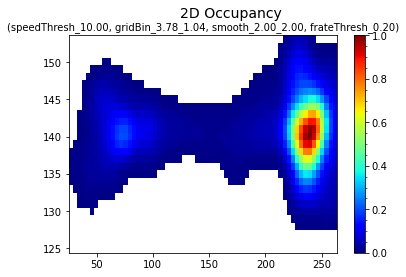

In [164]:
# curr_occupancy_plotter.active_time_dependent_placefields.occupancy

# curr_occupancy_plotter.active_time_dependent_placefields.occupancy
# curr_occupancy_plotter.active_time_dependent_placefields.xbin

# active_time_dependent_placefields2D.curr_normalized_occupancy
active_time_dependent_placefields2D.plot_occupancy()
# active_time_dependent_placefields2D.curr_seconds_occupancy



In [43]:
curr_occupancy_plotter.ui.imv.setImage(curr_occupancy_plotter.active_time_dependent_placefields.occupancy, xvals=curr_occupancy_plotter.active_time_dependent_placefields.xbin)
# Set the color map:
curr_occupancy_plotter.ui.imv.setColorMap(curr_occupancy_plotter.params.cmap)
    
# curr_occupancy_plotter.ui.imv.update()
# pg.QtGui.QApplication.processEvents()

In [48]:
curr_occupancy_plotter.ui.imv.set

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image, pyqtplot_plot_image_array
import time

def _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ plots a single result at a given time.
    
    Creates the figures if needed, otherwise updates the existing ones.
    
    """
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.

    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map

    imv = output_plots_dict.get('occupancy', {}).get('imv', None)
    if imv is None:
        # Otherwise build the plotter:
        occupancy_app, occupancy_win, imv = pyqtplot_plot_image(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, occupancy)
        output_plots_dict['occupancy'] = dict(zip(('app', 'win', 'imv'), (occupancy_app, occupancy_win, imv)))   
        occupancy_win.show()
    else:
        # Update the existing one:
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)

    pg.QtGui.QApplication.processEvents() # call to ensure the occupancy gets updated before starting the placefield plots:
    
    img_item_array = output_plots_dict.get('placefields', {}).get('img_item_array', None)
    if img_item_array is None:
        # Create a new one:
        placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin,
                                                                                                                                           active_time_dependent_placefields2D.ratemap.normalized_tuning_curves, active_time_dependent_placefields2D.curr_raw_occupancy_map)#, 
        output_plots_dict['placefields'] = dict(zip(('app', 'win', 'root_render_widget', 'plot_array', 'img_item_array', 'other_components_array'), (placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array)))
        placefields_win.show()

    else:
        # Update the placefields plot if needed:
        images = curr_ratemap.tuning_curves # (43, 63, 63)
        for i, an_img_item in enumerate(img_item_array):
            image = np.squeeze(images[i,:,:])
            # Pre-filter the data:
            # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
            if drop_below_threshold is not None:
                image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
            # an_img_item.setImage(np.squeeze(images[i,:,:]))
            an_img_item.setImage(image)

    return output_plots_dict

In [ ]:
def pre_build_iterative_results(num_iterations=50, t_list=[], ratemaps_list=[]):
    """ 
    build up historical data arrays:
    
    Usage:
        t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
    """
    # t_list = []
    # ratemaps_list = []
    
    def _step_plot(time_step_seconds):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        t_list.append(t)
        with np.errstate(divide='ignore', invalid='ignore'):
            active_time_dependent_placefields2D.update(t)
        # Loop through and update the plots:
        # Get flat list of images:
        curr_ratemap = active_time_dependent_placefields2D.ratemap
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        # images = active_time_dependent_placefields2D.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
        # occupancy = curr_ratemap.occupancy
        ratemaps_list.append(curr_ratemap)
    #     for i, an_img_item in enumerate(img_item_array):
    #     # for i, a_plot in enumerate(plot_array):
    #         # image = np.squeeze(images[i,:,:])
    #         # Pre-filter the data:
    #         # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
    # #         if drop_below_threshold is not None:
    # #             image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
    #         an_img_item.setImage(np.squeeze(images[i,:,:]))
    
    for i in np.arange(num_iterations):
        _step_plot(time_step_seconds=1.0)
    
    return t_list, ratemaps_list

# Loop through the historically collected ratemaps and plot them:
def _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ Uses the previously built-up t_list and ratemaps_list (as computed by pre_build_iterative_results(...)) to plot the time-dependent results.
    requires:
    imv: a previously created single-image plotter:
    """
    num_historical_results = len(ratemaps_list)
    assert len(t_list) == len(ratemaps_list), f"len(t_list): {len(t_list)} needs to equal len(ratemaps_list): {len(ratemaps_list)}"
    
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {},
                            'placefields': {}} # make a new dictionary to hold the plot objects.
        
    for i in np.arange(num_historical_results):
        curr_t = t_list[i]
        # Set up
        # print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    
        pg.QtGui.QApplication.processEvents()
        time.sleep(0.1) # Sleep for 0.5 seconds

    return output_plots_dict


# Build the Historical Results:
t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
# Plot the historical results:
if output_plots_dict is None:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}
output_plots_dict = _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, output_plots_dict=output_plots_dict)

In [ ]:
# Compute the time-dependent ratemap info in real-time and plot them:
def _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ Uses the previously built-up t_list and ratemaps_list to plot the time-dependent results.
    requires:
    imv: a previously created single-image plotter:
    """
    # Compute the updated placefields/occupancy for the time t:
    with np.errstate(divide='ignore', invalid='ignore'):
        active_time_dependent_placefields2D.update(t)
    # Update the plots:
    curr_t = active_time_dependent_placefields2D.last_t
    curr_ratemap = active_time_dependent_placefields2D.ratemap

    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.
        
    # Plot the results directly from the active_time_dependent_placefields2D
    output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    pg.QtGui.QApplication.processEvents()
    
    return output_plots_dict

In [ ]:
def _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ performs num_iterations time steps of size time_step_seconds and plots the results. """
    for i in np.arange(num_iterations):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
        time.sleep(0.1) # Sleep for 0.5 seconds

try:
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}}
except NameError:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}

output_plots_dict = _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, output_plots_dict=output_plots_dict)

In [ ]:
output_plots_dict = {'occupancy': {}, 'placefields': {}} # clear the output plots dict
output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, spike_raster_window.spikes_window.active_time_window[1], output_plots_dict=output_plots_dict)

In [ ]:
def _on_window_updated(window_start, window_end):
    # print(f'_on_window_updated(window_start: {window_start}, window_end: {window_end})')
    global output_plots_dict
    ## Update only version:
    # with np.errstate(divide='ignore', invalid='ignore'):
    #     active_time_dependent_placefields2D.update(window_end) # advance the placefield display to the end of the window.
    ## Update and plot version:
    # t = window_end
    output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, window_end, output_plots_dict=output_plots_dict)
    
# spike_raster_window.connect_additional_controlled_plotter(_on_window_updated)

_on_window_updated(spike_raster_window.spikes_window.active_time_window[0], spike_raster_window.spikes_window.active_time_window[1])
sync_connection = spike_raster_window.spike_raster_plt_2d.window_scrolled.connect(_on_window_updated) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
active_time_dependent_placefields2D.plot_occupancy()

In [ ]:
# active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=False) # Works
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=True)

In [ ]:
# t_list
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_saving_to_disk=False, enable_spike_overlay=False)

In [ ]:
# ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(None, active_time_dependent_placefields2D, active_config_name)
occupancy_fig, occupancy_ax = active_time_dependent_placefields2D.plot_occupancy(identifier_details_list=[])

In [ ]:
i = 0
while (i < len(t_list)):
    curr_t = t_list[i]
    # Set up
    print(f'curr_t: {curr_t}')
    curr_ratemap = ratemaps_list[i]
    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map
    imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
    i += 1
    pg.QtGui.QApplication.processEvents()
    
print(f'done!')

In [ ]:
# Timer Update Approach:
timer = pg.QtCore.QTimer()
i = 0
def update():
    if (i < len(t_list)):
        curr_t = t_list[i]
        # Set up
        print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        occupancy = curr_ratemap.occupancy
        # occupancy = curr_ratemap.curr_raw_occupancy_map
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
        i += 1
    else:
        print(f'done!')
    # pw.plot(x, y, clear=True)

timer.timeout.connect(update)

In [ ]:
# timer.start(16)
timer.start(500)


In [ ]:
timer.stop()

In [ ]:
t_list

## Other

In [ ]:
curr_occupancy_weighted_tuning_maps_matrix = compute_occupancy_weighted_tuning_map(curr_seconds_occupancy, curr_firing_maps_matrix)
curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
xy = active_pos_df[['x','y']].to_numpy().T
x = xy[0,:] # (57247,)
y = xy[1,:]

In [ ]:
print(f'np.nanmin(xbin): {np.nanmin(xbin)}') # 34.412589400527594
print(f'np.nanmin(ybin): {np.nanmin(ybin)}') # 126.93492802111207

print(f'np.nanmax(xbin): {np.nanmax(xbin)}') # 257.2462592450022
print(f'np.nanmax(ybin): {np.nanmax(ybin)}') # 148.84479357012503
# active_pos_df.notnull() # (57247,)
# np.shape(x) # (57247,)

In [ ]:
app_mine, win_mine, imv_mine = pyqtplot_plot_image(xbin, ybin, curr_occupancy_map)
win_mine.show()

# Test Iterative building

In [ ]:
t = last_t + 1 # add one second
curr_t, curr_occupancy_map = update_occupancy_map(last_t, curr_occupancy_map, t, active_pos_df, active_spike_df)
curr_occupancy_map

In [ ]:
t = 2000.0 # the "current time" for which to build the best possible placefields
last_t, curr_occupancy_map = update_occupancy_map(0, curr_occupancy_map, t, active_pos_df, active_spike_df)

In [ ]:
from neuropy.analyses.placefields import PfND # for build_position_df_discretized_binned_positions
active_computation_config = active_session_computation_configs[0]
xbin, ybin, bin_info = PfND._bin_pos_nD(active_pos_df['x'].values, active_pos_df['y'].values, bin_size=active_computation_config.grid_bin) # bin_size mode

# ybin
np.nanmax(sess.position.to_dataframe().y) # 153.31348420699553
# np.nanmax(active_pos_df.y) # 148.32098247462739
ybin

In [ ]:
active_pos_df.iloc[19:50,:]

In [ ]:
# active_pos_df.iloc[21,:]

active_pos_df.isnull()

In [ ]:
# Alternative implemention for position dataframe bin counting using group_by
np.unique(active_pos_df.binned_x) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
np.unique(active_pos_df.binned_y) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, nan])

# active_current_pos_df = active_pos_df.position.time_sliced(0, 30000)

# np.unique(active_current_pos_df.binned_x) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
# np.unique(active_current_pos_df.binned_y) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, nan])

curr_grouped_occupancy_map = np.zeros((n_xbins, n_ybins), dtype=int) # create an initially zero occupancy map
grouped = active_pos_df[['t','binned_x','binned_y']].groupby(['binned_x','binned_y'])
grouped_count = grouped.count()
# grouped_count.index.to_flat_index()

flat_indicies = grouped_count.index.to_flat_index()
counts = grouped_count['t'].to_numpy()

# for (xbin_label, ybin_label), count in current_bin_counts.iteritems():

# curr_grouped_occupancy_map[np.array(grouped_count.index.to_flat_index())] = grouped_count.values


for i in np.arange(len(counts)):
    curr_grouped_occupancy_map[flat_indicies[i]] = counts[i]

curr_grouped_occupancy_map
# for idx, group in grouped_count.iteritems():
#     print(idx)
    
    # curr_grouped_occupancy_map
    
np.sum(np.sum(curr_grouped_occupancy_map)) # 55206
active_pos_df

In [ ]:
# 

np.shape(active_computed_data['pf2D'].ratemap.xbin) # (60,)
np.shape(active_computed_data['pf2D'].ratemap.ybin) # (22,)

np.shape(active_computed_data['pf2D'].ratemap.xbin_centers) # (59,)
np.shape(active_computed_data['pf2D'].ratemap.ybin_centers) # (21,)

# np.shape(active_computed_data['pf2D'].ratemap.occupancy) # (59, 21)

# active_spike_df
# xbin_labels

In [ ]:
# active_pos_df['binned_x']
# binned_x_vals = active_pos_df['binned_x'].astype(float, copy=True).to_numpy()
# binned_y_vals = active_pos_df['binned_y'].astype(float, copy=True).to_numpy() # 57247

binned_x_indicies = active_pos_df['binned_x'].astype(float, copy=True).to_numpy()
binned_y_indicies = active_pos_df['binned_y'].astype(float, copy=True).to_numpy() # 57247

active_pos_df['binned_x_indicies'] = binned_x_indicies
active_pos_df['binned_y_indicies'] = binned_y_indicies
# np.unique(binned_x_vals) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
# binned_y_vals
# active_pos_df['binned_y']
np.shape(np.where(np.isnan(binned_x_vals))) # (1, 1321)
np.shape(np.where(np.isnan(binned_y_vals))) # (1, 768)

# np.where(pd.isnull(active_pos_df[['binned_x_indicies','binned_y_indicies']]))
# np.where(pd.isna(active_pos_df[['binned_x_indicies','binned_y_indicies']]))

np.where(pd.isnull(active_pos_df['binned_x_indicies']))

any_row_nan_indicies = np.where(np.logical_or(pd.isnull(active_pos_df['binned_x_indicies']), pd.isnull(active_pos_df['binned_y_indicies'])))
any_row_nan_indicies

print(f'any_row_nan_indicies: {np.shape(any_row_nan_indicies)}') # (1, 2041)


# np.where(pd.isnull(active_pos_df[['binned_x_indicies','binned_y_indicies']]))
# np.isnan(active_pos_df[['binned_x_indicies','binned_y_indicies']])

# active_pos_df['binned_x_indicies']

In [ ]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
# raw_occupancy = raw_occupancy.T
fig = plt.figure(figsize=(7, 3))
# ax = fig.add_subplot(111, title='imshow: square bins')
# plt.imshow(raw_occupancy, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = fig.add_subplot(111, title='NonUniformImage: interpolated', aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
print(f'xcenters: {xcenters.shape}, ycenters: {ycenters.shape}, raw_occupancy: {raw_occupancy.shape}')
im.set_data(xcenters, ycenters, raw_occupancy.T)
ax.images.append(im)
plt.show()

In [ ]:
current_bin_counts['binned_x']

# current_bin_counts.index.to_flat_index()

for name, group in grouped:
    print(name)
    print(group)

In [ ]:
# Binning in Time:
aligned_active_pos_df = active_pos_df.copy()

time_window_edges_time_delta = pd.to_timedelta(active_one_step_decoder.time_window_edges, unit="sec") # convert the windows to timedeltas as well to allow efficient comparison
time_window_edges_time_delta # length=1718

# aligned_active_pos_df.between_time

# aligned_active_pos_df.at_time(pho_custom_decoder.time_window_edges)

# pho_custom_decoder.time_window_edges
# aligned_active_pos_df.align(time_window_edges_time_delta, fill_value=np.nan)

# build_position_df_time_window_idx(active_pos_df, pho_custom_decoder.active_time_window_centers)

# pho_custom_decoder.active_time_window_centers
# pho_custom_decoder.time_window_edges

# s21, s22 = ts_2.align(ts_1, fill_value=0)

# active_sess.position.df
# aligned_active_pos_df

In [ ]:
pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)


def spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=True):
    """ Computes several different normalizations of binned firing rate and spike counts, optionally plotting them. 
    
    Usage:
        pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
        enable_plots = True
        unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
        spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:
    """
    # produces a fraction which indicates which proportion of the window's firing belonged to each unit (accounts for global changes in firing rate (each window is scaled by the toial spikes of all cells in that window)
    unit_specific_time_binned_spike_proportion_global_fr_normalized = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.total_spike_counts_per_window
    if enable_plots:
        plt.figure(num=5)
        plt.imshow(unit_specific_time_binned_spike_proportion_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Proportion of Window Spikes')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Activity')

    # print(pho_custom_decoder.time_window_edges_binning_info.step)
    # print(f'pho_custom_decoder: {pho_custom_decoder}')
    # np.shape(pho_custom_decoder.F) # (1856, 64)

    unit_specific_time_binned_firing_rate = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.time_window_edges_binning_info.step
    # print(unit_specific_time_binned_firing_rate)
    if enable_plots:
        plt.figure(num=6)
        plt.imshow(unit_specific_time_binned_firing_rate, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Firing Rate')


    # produces a unit firing rate for each window that accounts for global changes in firing rate (each window is scaled by the firing rate of all cells in that window
    unit_specific_time_binned_firing_rate_global_fr_normalized = unit_specific_time_binned_spike_proportion_global_fr_normalized / pho_custom_decoder.time_window_edges_binning_info.step
    if enable_plots:
        plt.figure(num=7)
        plt.imshow(unit_specific_time_binned_firing_rate_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates (Global Normalized)')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Firing Rate')
        
        
    # Special:
    # pho_custom_decoder.unit_specific_time_binned_spike_counts
    # unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
    

    # Return the computed values, leaving the original data unchanged.
    return unit_specific_time_binned_spike_proportion_global_fr_normalized, unit_specific_time_binned_firing_rate, unit_specific_time_binned_firing_rate_global_fr_normalized


unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median
# unit_specific_binned_spike_count_mean.shape # (64, )


# pho_custom_decoder.unit_specific_time_binned_spike_counts
# pho_custom_decoder.time_window_edges
# pho_custom_decoder.time_window_edges_binning_info
# pho_custom_decoder.total_spike_counts_per_window
# curr_kdiba_pipeline.pf.xbin


# active_pos_df = curr_kdiba_pipeline.filtered_sessions['maze1'].position.to_dataframe()
# time_window_edges, time_window_edges_binning_info = compute_spanning_bins(active_pos_df['x'].to_numpy(), bin_size=max_time_bin_size) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
# assert np.shape(time_window_edges)[0] < np.shape(spikes_df)[0], f'spikes_df[time_variable_name]: {np.shape(spikes_df[time_variable_name])} should be less than time_window_edges: {np.shape(time_window_edges)}!'

# active_sess.position.df

# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df['t'].to_numpy(), active_pos_df[['x','y']].to_numpy())
# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df.index, active_pos_df['x'])
# active_aligned_pos_df

In [ ]:
# from pyphoplacecellanalysis.General.Decoder.decoder_result import DecoderResultDisplayingPlot2D
# def _display_decoder_result():
#     renderer = DecoderResultDisplayingPlot2D(pho_custom_decoder, active_pos_df)
#     def animate(i):
#         # print(f'animate({i})')
#         return renderer.display(i)
#     interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_decoder_result, 'maze1', show_posterior=True) # works!

In [ ]:
# @pn.interact(i=(0,pho_custom_decoder.num_time_windows,1,0))
# @interact(i=pn.widgets.IntSlider(start=0,end=pho_custom_decoder.num_time_windows,step=1,value=0))

# ani = FuncAnimation(renderer.fig, animate, interval=300)
# interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

# pn.Column('**A custom interact layout**', pn.Row(layout[0], layout[1]))

In [ ]:
curr_kdiba_pipeline.computation_results['maze2']

In [ ]:
_display_result(curr_kdiba_pipeline.computation_results['maze1'])
_display_result(curr_kdiba_pipeline.computation_results['maze2'])

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d


def _test_plotRaw_v_time(active_pf, cellind, speed_thresh=False, alpha=0.5, ax=None):
        """ Builds one subplot for each dimension of the position data
        
        Updated to work with both 1D and 2D Placefields """   
        if ax is None:
            fig, ax = plt.subplots(active_pf.ndim, 1, sharex=True)
            fig.set_size_inches([23, 9.7])
        
        if not is_iterable(ax):
            ax = [ax]
            
        # plot trajectories
        if active_pf.ndim < 2:
            variable_array = [active_pf.x]
            label_array = ["X position (cm)"]
        else:
            variable_array = [active_pf.x, active_pf.y]
            label_array = ["X position (cm)", "Y position (cm)"]
            
        for a, pos, ylabel in zip(ax, variable_array, label_array):
            a.plot(active_pf.t, pos)
            a.set_xlabel("Time (seconds)")
            a.set_ylabel(ylabel)
            pretty_plot(a)

        # Grab correct spike times/positions
        if speed_thresh:
            spk_pos_, spk_t_ = active_pf.run_spk_pos, active_pf.run_spk_t
        else:
            spk_pos_, spk_t_ = active_pf.spk_pos, active_pf.spk_t

        # plot spikes on trajectory
        for a, pos in zip(ax, spk_pos_[cellind]):
            a.plot(spk_t_[cellind], pos, ".", color=[0, 0, 0.8, alpha])

        # Put info on title
        ax[0].set_title(
            "Cell "
            + str(active_pf.cell_ids[cellind])
            + ":, speed_thresh="
            + str(active_pf.speed_thresh)
        )
        return ax


def compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False):
    """ Takes input from compute_lap_to_lap_reliability(...) to build the actual reliability metrics """
    # Actual Computations of Reliability:
    out_pairwise_pair_results = np.zeros_like(out_within_lap_spikes_overlap)
    
    # do simple diff:
    laps_spikes_overlap_diff = np.diff(out_within_lap_spikes_overlap, axis=1) # the element-wise diff of the overlap. Shows changes.
    out_pairwise_pair_results[:, 1:] = laps_spikes_overlap_diff
    # out_pairwise_pair_results[:, -1] = np.zeros_like(out_within_lap_spikes_overlap[:,0])
    
    # do custom pairwise operation:
#     for first_item_lap_idx, next_item_lap_idx in list(out_pairwise_flat_lap_indicies):
#         first_item = out_within_lap_spikes_overlap[:, first_item_lap_idx]
#         next_item = out_within_lap_spikes_overlap[:, next_item_lap_idx]
#         out_pairwise_pair_results[:, next_item_lap_idx] = (first_item * next_item) # the result should be stored in the index of the second item, if we're doing the typical backwards style differences.
#         # print(f'np.max(out_pairwise_pair_results[:, next_item_lap_idx]): {np.max(out_pairwise_pair_results[:, next_item_lap_idx])}')

    if debug_print: 
        print(f'max out: {np.max(out_pairwise_pair_results)}')
        
    lap_ids 
    flat_lap_idxs = np.arange(len(lap_ids))
    
    
    # add to the extant plot as a new color:
    if plot_results:
        for lap_idx, lap_ID in zip(flat_lap_idxs, lap_ids):
            # curr_lap_alt_ax = axs[lap_idx]
            if plot_horizontal:
                curr_lap_alt_ax = axs[lap_idx].twiny()
                curr_lap_alt_ax.plot(out_pairwise_pair_results[:, lap_idx], out_digitized_position_bins, '--r')
            else:
                # vertical
                curr_lap_alt_ax = axs[lap_idx].twinx()
                curr_lap_alt_ax.plot(out_digitized_position_bins, out_pairwise_pair_results[:, lap_idx], '--r')
            
    cum_laps_reliability = np.cumprod(out_within_lap_spikes_overlap, axis=1)
    all_laps_reliability = np.prod(out_within_lap_spikes_overlap, axis=1, keepdims=True)
    
    if plot_results:
        fig_result, axs_result = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(24, 40))
        axs_result[0].plot(out_digitized_position_bins, all_laps_reliability, 'r')
        axs_result[1].plot(out_digitized_position_bins, cum_laps_reliability, 'r')

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [ ]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

# 3D Lap Plotting Experimentation

In [ ]:
from itertools import islice # for Pagination class
import pyvista as pv
import pyvistaqt as pvqt
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin
from pyphocorehelpers.gui.PyVista.PhoCustomVtkWidgets import PhoWidgetHelper
from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import perform_plot_flat_arena, _build_flat_arena_data

""" Test Drawing Spike Lines """
# from pyphoplacecellanalysis.Pho3D.spikes import draw_line_spike, lines_from_points
from pyphoplacecellanalysis.Pho3D.points import interlieve_points

from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_pointdata_df

def _plot_all_lap_spikes(p, sess, included_cell_IDXs, included_lap_IDXs, debug_print=True, lap_start_z=0.0, lap_id_dependent_z_offset=10.0):
    should_reinterpolate_spike_positions = False
        
    def _plot_single_spikes(p, cell_specific_spikes_dfs, placefield_cell_index):
        curr_cell_spike_df = cell_specific_spikes_dfs[placefield_cell_index]
        # curr_cell_spike_df['z_fixed'] = np.full_like(active_flat_df['x'].values, 1.1)
        pdata = build_active_spikes_plot_pointdata_df(curr_cell_spike_df)

        # curr_cell_spike_times = curr_cell_spike_df[curr_cell_spike_df.spikes.time_variable_name].to_numpy()  # (271,)
        # curr_cell_spike_positions = curr_cell_spike_df['x','y'].to_numpy()  # (271,)

        # lines_from_points(
        # p[0,0].add_points(pdata, name='plot_single_spikes_points', render_points_as_spheres=True, point_size=5.0)

        # Build offset points and spike data:
        spike_height = max((lap_id_dependent_z_offset * 0.6), 0.5) # half the line height

        # start_points = pdata.points.copy()
        # end_points = start_points.copy()
        # # end_points[:,2] # get z values
        # end_points[:,2] = end_points[:,2] + spike_height
        # all_points = interlieve_points(start_points, end_points)
        # lines_poly_data = pv.PolyData()
        # lines_poly_data.points = all_points
        # # cells = np.hstack(([2, 0, 1],[2, 1, 2]))
        # num_lines = np.shape(start_points)[0]
        # cells = [[2, 2*i, 2*i+1] for i in np.arange(num_lines)]
        # lines_poly_data.lines = cells
        
        p[0,0].add_mesh(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0, color='white')        
        
        # p[0,0].add_points(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0)
        # p[0,0].add_mesh(lines_poly_data, name=f'plot_single_spikes_lines[{placefield_cell_index}]', render_points_as_spheres=False, point_size=5.0)
        # return {'pdata':pdata, 'lines_poly_data':lines_poly_data}
        
        return {'pdata':pdata}
    
    time_variable_name = sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
    # sets the 'z_fixed' value for all spikes in sess.spikes_df, which will be used to plot them as points
    sess.spikes_df['z'] = lap_start_z + (lap_id_dependent_z_offset * sess.spikes_df.lap.to_numpy())

    if debug_print:
        print(f'sess.laps.lap_id: {sess.laps.lap_id}')
        
    included_cell_IDXs = np.array(included_cell_IDXs)
    included_lap_IDXs = np.array(included_lap_IDXs)
    
    # ensure that only lap_ids included in this session are used:
    included_lap_ids = sess.laps.lap_id[included_lap_IDXs]
    possible_included_lap_ids = np.unique(sess.spikes_df.lap.values)
    if debug_print:
        print(f'np.unique(sess.spikes_df.lap.values): {np.unique(sess.spikes_df.lap.values)}')
    included_lap_ids = included_lap_ids[np.isin(included_lap_ids, possible_included_lap_ids)]
    if debug_print:
        print(f'included_lap_ids: {included_lap_ids}')
    
    # get the included cell IDs
    included_cell_IDs = np.array(sess.spikes_df.spikes.neuron_ids)[included_cell_IDXs]
        
    # print(np.isin(['R','G','B','render_opacity'], sess.spikes_df.columns).all())

    # POSITIONS:
    curr_position_df, lap_specific_position_dfs, lap_specific_time_ranges, lap_specific_position_traces = LapsVisualizationMixin._compute_laps_position_data(sess)
    
    # SPIKES:
    # # grouped by lap
    # lap_grouped_spikes_df = sess.spikes_df.groupby('lap')
    # lap_specific_spikes_dfs = [lap_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_lap_ids] # dataframes split for each ID:

    # grouped by cell:
    # pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
    filtered_spikes_df = sess.spikes_df.copy()
    filtered_spikes_df = filtered_spikes_df[np.isin(filtered_spikes_df['lap'], included_lap_ids)] # get only the spikes that occur in one of the included laps for the filtered_spikes_df
    
    
    # Interpolate the spikes positions again:
    if should_reinterpolate_spike_positions:
        print('Re-interpolating spike positions...')
        filtered_spikes_df = filtered_spikes_df.spikes.interpolate_spike_positions(curr_position_df['t'].to_numpy(), curr_position_df['x'].to_numpy(), curr_position_df['y'].to_numpy())
        # filtered_spikes_df = FlattenedSpiketrains.interpolate_spike_positions(filtered_spikes_df, session.position.time, session.position.x, session.position.y, spike_timestamp_column_name=time_variable_name)
    
    cell_grouped_spikes_df = filtered_spikes_df.groupby('aclu')
    cell_specific_spikes_dfs = [cell_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_cell_IDs] # dataframes split for each ID:

    # lap_specific_position_dfs = _compute_laps_position_data(sess)

    # # Positions:
    # curr_position_df = sess.compute_position_laps()
    # included_pos_lap_ids = np.unique(curr_position_df.lap.values)
    # print(f'np.unique(curr_position_df.lap.values): {np.unique(curr_position_df.lap.values)}')
    # included_pos_lap_ids = included_pos_lap_ids[np.isin(included_pos_lap_ids, sess.laps.lap_id)]
    # included_pos_lap_ids

    # print(f'included_pos_lap_ids: {included_pos_lap_ids}')

    # lap_grouped_position_df = curr_position_df.groupby('lap')
    # lap_specific_position_dfs = [lap_grouped_position_df.get_group(i)[['t','aclu','x','y','lin_pos']] for i in included_lap_ids] # dataframes split for each ID:

    for i, curr_cell_ID in enumerate(included_cell_IDs):
        plot_data_dict = _plot_single_spikes(p, cell_specific_spikes_dfs, i)


# sess = curr_kdiba_pipeline.filtered_sessions['maze']
# included_cell_IDXs = [6]
# included_lap_IDXs = [2, 3]
# _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_IDXs, included_lap_IDXs)

from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

lap_start_z = 0.0
# lap_id_dependent_z_offset = 0.0
lap_id_dependent_z_offset = 3.0
# curr_kdiba_pipeline.active_configs['maze1'].lap_id_dependent_z_offset = 3.0

def _display_testing(sess, computation_result, active_config, extant_plotter=None):
    """ Testing of plot_lap_trajectories_2d """
    # print(f'active_config.plotting_config: {active_config.plotting_config}')
    single_combined_plot=True
    if single_combined_plot:
        default_plotting = True
    else:
        default_plotting = False
    active_config.plotting_config.plotter_type = 'MultiPlotter'
    # print(f'active_config.plotting_config: {active_config.plotting_config}')
    iplapsDataExplorer = InteractiveCustomDataExplorer(active_config, sess, extant_plotter=extant_plotter)
    pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=extant_plotter, default_plotting=default_plotting)
    # included_cell_idxs = None
    included_cell_idxs = [0, 1]
    # included_lap_idxs = [2, 5, 9, 12]
    included_lap_idxs = [2]
    # All
    # included_cell_idxs = np.arange(len(sess.spikes_df.spikes.neuron_ids))
    # included_lap_idxs = np.arange(len(sess.laps.lap_id))
    from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
    pActiveInteractiveLapsPlotter, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0, included_lap_idxs=included_lap_idxs, single_combined_plot=single_combined_plot, 
                                                                         lap_start_z = lap_start_z, lap_id_dependent_z_offset = lap_id_dependent_z_offset,
                                                                         existing_plotter=pActiveInteractiveLapsPlotter)

    # add the spikes for the curves:
    _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_idxs, included_lap_idxs, lap_start_z=lap_start_z, lap_id_dependent_z_offset=lap_id_dependent_z_offset)
    return iplapsDataExplorer, pActiveInteractiveLapsPlotter


# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']

# curr_result_label = 'maze1'
# sess = curr_active_pipeline.filtered_sessions[curr_result_label]
# sess = curr_active_pipeline.sess

pActiveInteractiveLapsPlotter = None
try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer, pActiveInteractiveLapsPlotter = _display_testing(sess, curr_active_pipeline.computation_results[curr_result_label], curr_active_pipeline.active_configs[curr_result_label],
                                                                     extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter.show()

In [ ]:
sess.laps

In [ ]:
# sess.position.


In [ ]:
# lines_from_points(pdata.points)

np.shape(all_points)

In [ ]:
p, laps_pages = _plot_lap_trajectories_combined_plot_3d(curr_kdiba_pipeline.sess, curr_num_subplots=5, single_combined_plot=False)
p.show()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

In [ ]:
# sess.laps.to_dataframe()
# sess.position.to_dataframe()
# sess.position
# curr_active_pipeline.sess.laps

# curr_active_pipeline.sess.laps

curr_active_pipeline.sess.position.to_dataframe()